In this section, a time analysis neural network is implemented to predict future stock closing prices, based on previous closing prices. Cleaning code copied from previous file. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn import preprocessing
from keras.callbacks import EarlyStopping

filepath = "/Users/Ivan/Desktop/Cse 391 lectures/data.csv"
data = pd.read_csv(filepath)
print("Data Shape: ", data.shape, "\n")
print(data.info())
display(data.describe())
display(data.head())

# Eliminating Outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

df_outliers = data[((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
df = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

display(df_outliers)
display(df.describe())

#Graph 1.2: signal vs spy_close_price
df.plot(kind = 'scatter', x = 'signal', y = 'spy_close_price', rot = 70)
plt.xlabel("signal")
plt.ylabel("spy_close_price")
plt.title("Signal vs SP500 Index")
plt.show()

# Converting 'date' Data to Datetimes
#df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

Data Shape:  (667, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
date               667 non-null int64
signal             667 non-null float64
spy_close_price    667 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.7 KB
None


Using TensorFlow backend.


,date,signal,spy_close_price
count,6.670000e+02,667.000000,667.000000
mean,2.012939e+07,5.166603,163.169369
std,7.762422e+03,23.392818,39.210384
min,2.012010e+07,-3.802670,127.495000
25%,2.012083e+07,3.418083,140.880000
50%,2.013051e+07,3.893689,159.750000
75%,2.014010e+07,4.408313,181.500000
max,2.014083e+07,432.961165,710.310000


,date,signal,spy_close_price
0,20120103,3.107767,127.495
1,20120104,3.107282,127.700
2,20120105,3.099757,128.040
3,20120106,3.134223,127.710
4,20120109,3.135922,128.020


,date,signal,spy_close_price
303,20130326,-3.802670,156.1900
421,20130912,4.193204,618.9500
422,20130913,4.143689,619.3300
423,20130916,4.124515,710.3100
459,20131105,429.514563,176.2700
460,20131106,432.961165,177.1700
570,20140414,0.004560,182.9401
571,20140415,0.454976,184.2000
572,20140416,0.455898,186.1250


,date,signal,spy_close_price
count,6.580000e+02,658.000000,658.000000
mean,2.012933e+07,3.911967,160.824444
std,7.778235e+03,0.525500,21.488326
min,2.012010e+07,3.099757,127.495000
25%,2.012083e+07,3.419053,140.817500
50%,2.013050e+07,3.890291,159.245000
75%,2.013788e+07,4.409072,180.985000
max,2.014083e+07,4.881311,200.710000


<Figure size 640x480 with 1 Axes>

MinMaxScaler was used to scale data to be ready for input into the neural network model. MinMaxScaler is sensitive to outliers, so eliminating outliers was done beforehand. The scaler rescales the data so that they are in the range [0,1]. Additionally, this was used because if needed the transform can be inverted back to the original data. 

In [2]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

C:\Users\Anthony Girard\Anaconda3\envs\TensorFlowEnv\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


BELOW CODE WAS TAKEN FROM https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

This code prepares the data for input into a time series neural network by framing it as a supervised learning data set. Time steps are created as new pandas columns, that represent current values of features (t), while original data is labeled as previous data (t-1). This is an example of one-step forecasting.



In [3]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

TS_data = series_to_supervised(scaled_df)
TS_data.drop(TS_data.columns[[0,1,3,4]], axis=1, inplace=True)
TS_data.columns = ['spy close price(prev)','spy close price(curr)']
print(type(TS_data))
print(TS_data.head())

<class 'pandas.core.frame.DataFrame'>
   spy close price(prev)  spy close price(curr)
1               0.000000               0.002800
2               0.002800               0.007444
3               0.007444               0.002937
4               0.002937               0.007171
5               0.007171               0.022331


Below the supervised learning data was separated between training data (75% of data) and testing data (other 25%) on the basis of Date. The training data comprises the first 75% entries, while the latter 25% is used for testing.

In [4]:
data = TS_data.values
boundary = int(data.shape[0]*.75)
train_x = data[:boundary, :-1]
test_x = data[boundary:, :-1]
train_y = data[:boundary, -1]
test_y = data[boundary:, -1]

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

n_rows = train_x.shape[1]
n_cols = train_x.shape[2]

The following code blocks are various LSTM neural network models that were created in order to test what model structure and characteristics best and most efficiently predicted the futute stock market closing prices based on the previous prices. The number of hidden layers, number of hidden layer nodes, activation functions and model optimizers were varied. The loss function used was Mean-Square Error.

In [5]:
model1 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model1.add(LSTM(50, activation='relu', input_shape=(n_rows, n_cols)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist1 = model1.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [6]:
model2 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_rows, n_cols)))
model2.add(LSTM(32, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist2 = model2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [7]:
model3 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model3.add(LSTM(1000, activation='relu', input_shape=(n_rows, n_cols)))
model3.add(Dense(1))
model3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist3 = model3.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [8]:
model4 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model4.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(n_rows, n_cols)))
model4.add(LSTM(50, activation='relu'))
model4.add(Dense(1))
model4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist4 = model4.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [9]:
model4_2 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model4_2.add(LSTM(1000, activation='sigmoid', return_sequences=True, input_shape=(n_rows, n_cols)))
model4_2.add(LSTM(50, activation='sigmoid'))
model4_2.add(Dense(1))
model4_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist4_2 = model4_2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [10]:
model3_2 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model3_2.add(LSTM(1000, activation='sigmoid', input_shape=(n_rows, n_cols)))
model3_2.add(Dense(1))
model3_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
hist3_2 = model3_2.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

In [11]:
model3_3 = Sequential()
early_stopping_monitor = EarlyStopping(patience=3)
model3_3.add(LSTM(1000, activation='relu', input_shape=(n_rows, n_cols)))
model3_3.add(Dense(1))
model3_3.compile(optimizer = 'AdaDelta', loss = 'mean_squared_error', metrics=['accuracy'])
hist3_3 = model3_3.fit(train_x, train_y, validation_data=(test_x, test_y), epochs = 30, callbacks=[early_stopping_monitor], verbose=False)

The number of epochs seemed to make little to no difference as effective models saw their loss functions reach a flat point at around 10-15 epochs. An early stopping monitor was used in order to stop models from continuing to 30 epochs if significant progress was not made in what we set to 3 consecutive epochs. 

Adam and AdaDelta optimizers were used to compile the model, as both are adaptive learning-method algorithms, which are characterised by converging quickly, high efficiency and accuracy, and robustness to problems such as vanishing learning rate, slow convergence or high variance in the parameter updates. They seemed to have very little difference in effect on the results.

ReLu and sigmoid activation functions were used in the models. ReLu seemed to provide significantly lower loss metrics.

One, two, and three (though not shown) hidden layers were used. Best results were found using one hidden layer. The number of hidden layer nodes was varied as well, and the model seemed to respond best to a high number of hidden nodes in the one hidden layer. More than 1000 nodes was not used, as the computer was not able to handle much more than that.

The models loss functions were plotted below, the best being model 3 and model 3_3. These models both had 1 hidden layer, with 1000 nodes, a ReLu activation function, but differed in the optimizer function. 

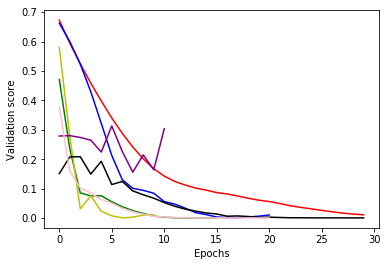

In [12]:
plt.plot(hist1.history['val_loss'], 'r', hist2.history['val_loss'], 'b', hist3.history['val_loss'], 'g', hist4.history['val_loss'], 'y', hist4_2.history['val_loss'], 'purple', hist3_2.history['val_loss'], 'black', hist3_3.history['val_loss'], 'pink')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

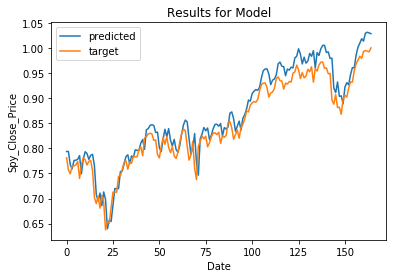

R-Square: 0.9018869411322442
Mean-Square Error: 0.0007105367238224455


In [13]:
pred = model3.predict(test_x)
plt.title('Results for Model')
plt.xlabel('Date')
plt.ylabel('Spy_Close_Price')

plt.plot(pred, label='predicted')
plt.plot(test_y, label='target')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
r2_score = r2_score(test_y, pred)
print("R-Square:", r2_score)
mse = mean_squared_error(test_y, pred)
print("Mean-Square Error:", mse)

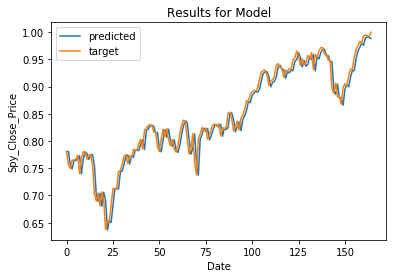

R-Square: 0.958187071286316
Mean-Square Error: 0.0003028100614178934


In [14]:
pred = model3_3.predict(test_x)
plt.title('Results for Model')
plt.xlabel('Date')
plt.ylabel('Spy_Close_Price')

plt.plot(pred, label='predicted')
plt.plot(test_y, label='target')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error, r2_score
r2_score = r2_score(test_y, pred)
print("R-Square:", r2_score)
mse = mean_squared_error(test_y, pred)
print("Mean-Square Error:", mse)

The two chosen models were used to predict future closing prices. Model3_3 had a higher R-Square Value (0.95819) and lower MSE (0.00030). The only difference between the two models being Model3_3 used AdaDelta as the optimization function, while Model3 used Adam optimizer.